## INFORMACJE O ŚRODOWISKU

In [ ]:
!nvidia-smi

Thu Sep  7 03:54:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

## POBRANIE I ROZPAKOWANIE ZBIORU DANYCH

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Pobieranie danych ze strony gdzie umieszczona jest baza

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar -xvf images.tar

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Images/n02109047-Great_Dane/n02109047_34148.jpg
Images/n02109047-Great_Dane/n02109047_34162.jpg
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_74

## IMPORT BIBLIOTEK I MODUŁÓW

In [ ]:
import os
import pickle
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as torchvision_models
import torch.optim as optim
from tqdm.notebook import tqdm
from PIL import Image
import shutil
%matplotlib inline

## INFORMACJE NA TEMAT BAZY OBRAZÓW ORAZ PODZIAŁ NA PODZBIORY

Podział danych na podkatalogi

In [ ]:
# Ścieżka do katalogu źródłowego Stanford Dogs
SOURCE_DIR = "Images"

# Ścieżki do katalogów docelowych
TRAIN_DIR = "train"
VALIDATE_DIR = "validate"
TEST_DIR = "test"

# Procentowa proporcja podziału
TRAIN_RATIO = 0.7
VALIDATE_RATIO = 0.1
# TEST_RATIO będzie wynosiło 1 - (TRAIN_RATIO + VALIDATE_RATIO)

def split_dataset(source_dir, train_dir, validate_dir, test_dir, train_ratio, validate_ratio):
    if not os.path.exists(source_dir):
        print(f"Katalog źródłowy {source_dir} nie istnieje!")
        return

    np.random.seed(213)

    for class_name in os.listdir(source_dir):
        # Tworzenie katalogów dla klas w zbiorach docelowych
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validate_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Lista wszystkich obrazów w klasie
        images = os.listdir(os.path.join(source_dir, class_name))
        np.random.shuffle(images)

        # Obliczanie liczby obrazów w każdym podzbiorze
        n_train = int(len(images) * train_ratio)
        n_validate = int(len(images) * validate_ratio)
        n_test = len(images) - n_train - n_validate

        # Podział obrazów
        for i, img in enumerate(images):
            source_img = os.path.join(source_dir, class_name, img)
            if i < n_train:
                shutil.copy(source_img, os.path.join(train_dir, class_name, img))
            elif i < (n_train + n_validate):
                shutil.copy(source_img, os.path.join(validate_dir, class_name, img))
            else:
                shutil.copy(source_img, os.path.join(test_dir, class_name, img))

split_dataset(SOURCE_DIR, TRAIN_DIR, VALIDATE_DIR, TEST_DIR, TRAIN_RATIO, VALIDATE_RATIO)


In [ ]:
dataset = ImageFolder('Images')
print(len(dataset)) #ilość zdjęć
len(dataset.classes) # ilość klas

20580


120

In [ ]:
breeds = [] #utworzenie listy klas - w tym przypadku ras psów

# Funkcja zmieniająca skomplikowane nazwy plików na wyłącznie nazwy ras
def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

## PODZIAŁ DANYCH NA TRENINGOWE, WALIDACYJNE I TESTOWE


Pobieranie raz podzielonych danych z dysku google aby zaoszczędzić czas na pobieraniu ze strony bazy oraz rozpakowywaniu pliku .tar

In [ ]:
test_ds = ImageFolder("test")
train_ds = ImageFolder("train")
val_ds = ImageFolder("validate")
len(train_ds), len(val_ds), len(test_ds)



(14355, 2009, 4216)

n02085936-Maltese_dog
<class 'PIL.Image.Image'>


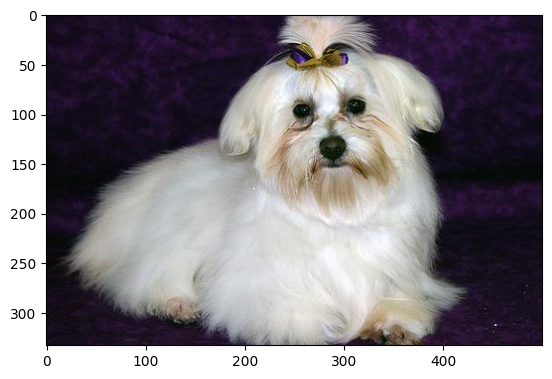

In [ ]:
img, label = train_ds[253]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

## TWORZENIE ZBIORÓW DANYCH ORAZ ICH KLAS


In [ ]:
#tworzenie customej klasy dataset aby ułatwić tworzenie data loaderów
class DogBreedDataset(Dataset):

    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)
            return img, label

In [ ]:
# Augmentacja dla danych treningowych
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
])

# Dla danych walidacyjnych i testowych tylko uporządkowanie rozmiarów
val_transform = transforms.Compose([
    transforms.Resize((256,256)), # Rozmiar zdjęć walidacyjnych
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)), # Rozmiar zdjęć testowych
    transforms.ToTensor(),
])

In [ ]:
#utworzenie zbiorów danych już po augmentacji
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

## SPRAWDZENIE DANYCH

0


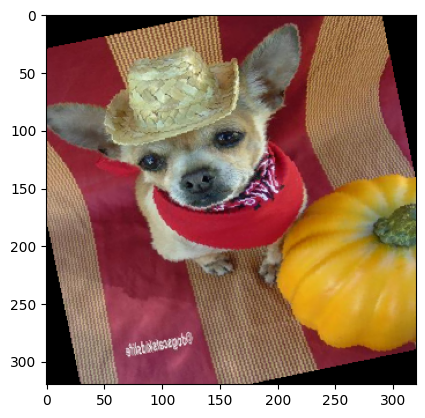

In [ ]:
img, label = train_dataset[5]
print(label)
plt.imshow(img.permute(1,2,0)) #permute służy do przystosowania obrazu dla funkcji plot

In [ ]:
batch_size = 64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
#funkcja do pokazania całej partii zdjęć

def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

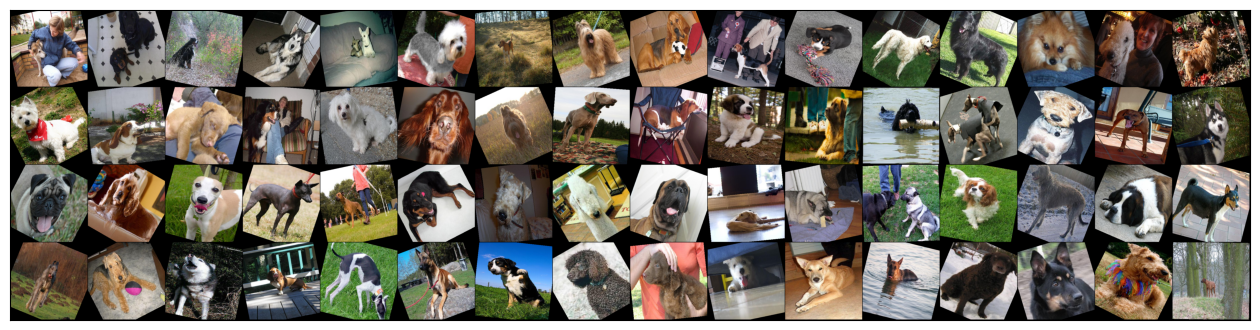

In [ ]:
show_batch(train_dl)

## DEFINICJA I INSTANCJE PRE-TRAINED MODELI

ResNet-50 Pre-trained model

In [ ]:
class DogBreedPretrainedResnet50(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torchvision_models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model1 = DogBreedPretrainedResnet50()
model1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.9MB/s]


DogBreedPretrainedResnet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

VGG16


In [ ]:
class DogBreedPretrainedVGG16(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torchvision_models.vgg16(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier[6].in_features
        self.network.classifier[6] = nn.Sequential(
            nn.Linear(num_ftrs, 120)
        )

    def forward(self, xb):
        return self.network(xb)


In [ ]:
model2 = DogBreedPretrainedVGG16()
model2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.0MB/s]


DogBreedPretrainedVGG16(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

MobileNetV2

In [ ]:
class DogBreedPretrainedMobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torchvision_models.mobilenet_v2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier[1].in_features
        self.network.classifier[1] = nn.Sequential(
            nn.Linear(num_ftrs, 120)
        )

    def forward(self, xb):
        return self.network(xb)


In [ ]:
model3 = DogBreedPretrainedMobileNetV2()
model3

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 7.26MB/s]


DogBreedPretrainedMobileNetV2(
  (network): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 

Inception V3

In [ ]:
class DogBreedPretrainedInceptionV3(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torchvision_models.inception_v3(pretrained=True)

        # Replace the main output layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 120)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model4 = DogBreedPretrainedInceptionV3()
model4

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 91.7MB/s]


DogBreedPretrainedInceptionV3(
  (network): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (C

VGG19

In [ ]:
class DogBreedPretrainedVGG19(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torchvision_models.vgg19(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier[6].in_features
        self.network.classifier[6] = nn.Sequential(
            nn.Linear(num_ftrs, 120)
        )

    def forward(self, xb):
        return self.network(xb)


In [ ]:
model5 = DogBreedPretrainedVGG19()
model5

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:29<00:00, 19.2MB/s]


DogBreedPretrainedVGG19(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

DenseNet121

In [ ]:
class DogBreedPretrainedDenseNet121(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torchvision_models.densenet121(pretrained=True)

        # Replace the classifier layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, 120)

    def forward(self, xb):
        return self.network(xb)


In [ ]:
model6 = DogBreedPretrainedDenseNet121()
model6

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 91.9MB/s]


DogBreedPretrainedDenseNet121(
  (network): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, e

Resnet 152

In [ ]:
class DogBreedPretrainedResnet152(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torchvision_models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model7 = DogBreedPretrainedResnet152()
model7

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 89.6MB/s]


DogBreedPretrainedResnet152(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## TRENOWANIE MODELI

In [ ]:
models = [model1, model2, model3, model4, model5, model6, model7]
history_list = []


for model in models:
  print(str(type(model)).split()[1][10:-2])

DogBreedPretrainedResnet50
DogBreedPretrainedVGG16
DogBreedPretrainedMobileNetV2
DogBreedPretrainedInceptionV3
DogBreedPretrainedVGG19
DogBreedPretrainedDenseNet121
DogBreedPretrainedResnet152


Trening i walidacja


In [ ]:
import gc

#sprawdzenie czy jest dostępne GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#funkcja straty
criterion = nn.CrossEntropyLoss()
#liczba epok
NUM_EPOCHS = 20
#lista modeli pretrained
# models = [model1, model2, model3, model4, model5, model6, model7]
# zmienione na podjedynczy model z powodu braku RAMu GPU
models = [model1]


history_list = []


for model in models:
    #przeniesienie modelu do GPU
    model = model.to(device)
    #zapis nazwy modelu
    model_name = str(type(model)).split()[1][10:-2]
    #zapis statystyk
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    history = {
        "model_name": model_name,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies
      }

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')  # Inicjujemy jako nieskończoność

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0.0
        correct_preds = 0
        for images, labels in tqdm(train_dl):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            if model_name == "DogBreedPretrainedInceptionV3":
                outputs, aux_outputs = model(images)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()

        #Zapis statystk po treningu
        train_acc = correct_preds
        train_losses.append(total_loss/len(train_dl.dataset))
        train_accuracies.append(train_acc/len(train_dl.dataset))


        torch.cuda.empty_cache()


        model.eval()
        val_loss = 0.0
        val_correct_preds = 0
        torch.cuda.empty_cache()
        with torch.no_grad():
            model.eval()
            for images, labels in val_dl:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                torch.cuda.empty_cache()
        #Zapis statystk po walidacji
        val_acc = val_correct_preds
        val_losses.append(val_loss/len(val_dl.dataset))
        val_accuracies.append(val_acc/len(val_dl.dataset))

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]\nTrain Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}\nVal Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}\n")
        # Sprawdzamy czy obecna strata walidacyjna jest najlepsza
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            #zapisywanie modelu do pliku
            model_file_name = f"/content/drive/MyDrive/Colab Notebooks/dane/pytorch/{model_name}_full_model.pth"
            torch.save(model, model_file_name)

        torch.cuda.empty_cache()

    print(f"Training complete of model: {model_name} complete!")
    #zapisywanie historii
    history_list.append(history)
    with open(f'/content/drive/MyDrive/Colab Notebooks/dane/pytorch/history_list_{model_name}.pkl', 'wb') as f:
        pickle.dump(history_list, f)
    gc.collect()



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1/20]
Train Loss: 4.7787, Train Acc: 0.0127
Val Loss: 4.6954, Val Acc: 0.0149



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2/20]
Train Loss: 4.6257, Train Acc: 0.0170
Val Loss: 4.6542, Val Acc: 0.0174



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3/20]
Train Loss: 4.5663, Train Acc: 0.0182
Val Loss: 4.5644, Val Acc: 0.0209



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [4/20]
Train Loss: 4.4796, Train Acc: 0.0300
Val Loss: 4.4929, Val Acc: 0.0299



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [5/20]
Train Loss: 4.3341, Train Acc: 0.0403
Val Loss: 4.3085, Val Acc: 0.0383



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [6/20]
Train Loss: 4.1847, Train Acc: 0.0496
Val Loss: 4.2339, Val Acc: 0.0528



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [7/20]
Train Loss: 3.9874, Train Acc: 0.0708
Val Loss: 4.0198, Val Acc: 0.0652



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [8/20]
Train Loss: 3.8027, Train Acc: 0.0923
Val Loss: 3.8942, Val Acc: 0.0831



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [9/20]
Train Loss: 3.6269, Train Acc: 0.1184
Val Loss: 4.1121, Val Acc: 0.0876



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [10/20]
Train Loss: 3.4667, Train Acc: 0.1402
Val Loss: 3.8471, Val Acc: 0.1055



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [11/20]
Train Loss: 3.3049, Train Acc: 0.1641
Val Loss: 3.6727, Val Acc: 0.1399



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [12/20]
Train Loss: 3.1845, Train Acc: 0.1884
Val Loss: 3.4363, Val Acc: 0.1578



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [13/20]
Train Loss: 3.0515, Train Acc: 0.2137
Val Loss: 3.4122, Val Acc: 0.1737



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [14/20]
Train Loss: 2.9082, Train Acc: 0.2402
Val Loss: 4.0017, Val Acc: 0.1030



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [15/20]
Train Loss: 2.7679, Train Acc: 0.2722
Val Loss: 3.4825, Val Acc: 0.2220



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [16/20]
Train Loss: 2.6556, Train Acc: 0.2977
Val Loss: 3.2664, Val Acc: 0.2011



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [17/20]
Train Loss: 2.5212, Train Acc: 0.3238
Val Loss: 2.8906, Val Acc: 0.2534



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [18/20]
Train Loss: 2.4050, Train Acc: 0.3516
Val Loss: 2.7449, Val Acc: 0.2897



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [19/20]
Train Loss: 2.2738, Train Acc: 0.3806
Val Loss: 2.6631, Val Acc: 0.3116



  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [20/20]
Train Loss: 2.1649, Train Acc: 0.4050
Val Loss: 2.5275, Val Acc: 0.3509

Training complete of model: DogBreedPretrainedResnet50 complete!


Rysowanie wykresów

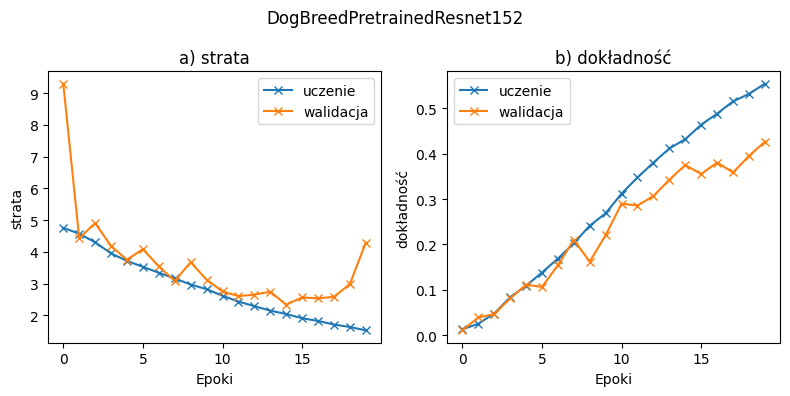

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/dane/pytorch/history_list_DogBreedPretrainedResnet152.pkl', 'rb') as f:
    l_history_list = pickle.load(f)

# Tworzenie wykresu dla straty

for num in range(0,len(l_history_list)):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8 ,4))  # 1 wiersz, 2 kolumny

    # Wykres dla straty
    ax1.plot(history_list[num]["train_losses"], label='uczenie', marker="x")
    ax1.plot(history_list[num]["val_losses"], label='walidacja', marker="x")
    ax1.set_title("a) strata")
    ax1.set_xlabel("Epoki")
    ax1.set_ylabel("strata")
    ax1.legend()

    # Wykres dla dokładności
    ax2.plot(history_list[num]["train_accuracies"], label='uczenie', marker="x")
    ax2.plot(history_list[num]["val_accuracies"], label='walidacja', marker="x")
    ax2.set_title("b) dokładność")
    ax2.set_xlabel("Epoki")
    ax2.set_ylabel("dokładność")
    ax2.legend()

    # Dodanie głównego tytułu
    fig.suptitle(history_list[num]["model_name"])

    # Ostateczne wyświetlenie wykresu
    plt.tight_layout()
    plt.show()




## PREDYKCJE

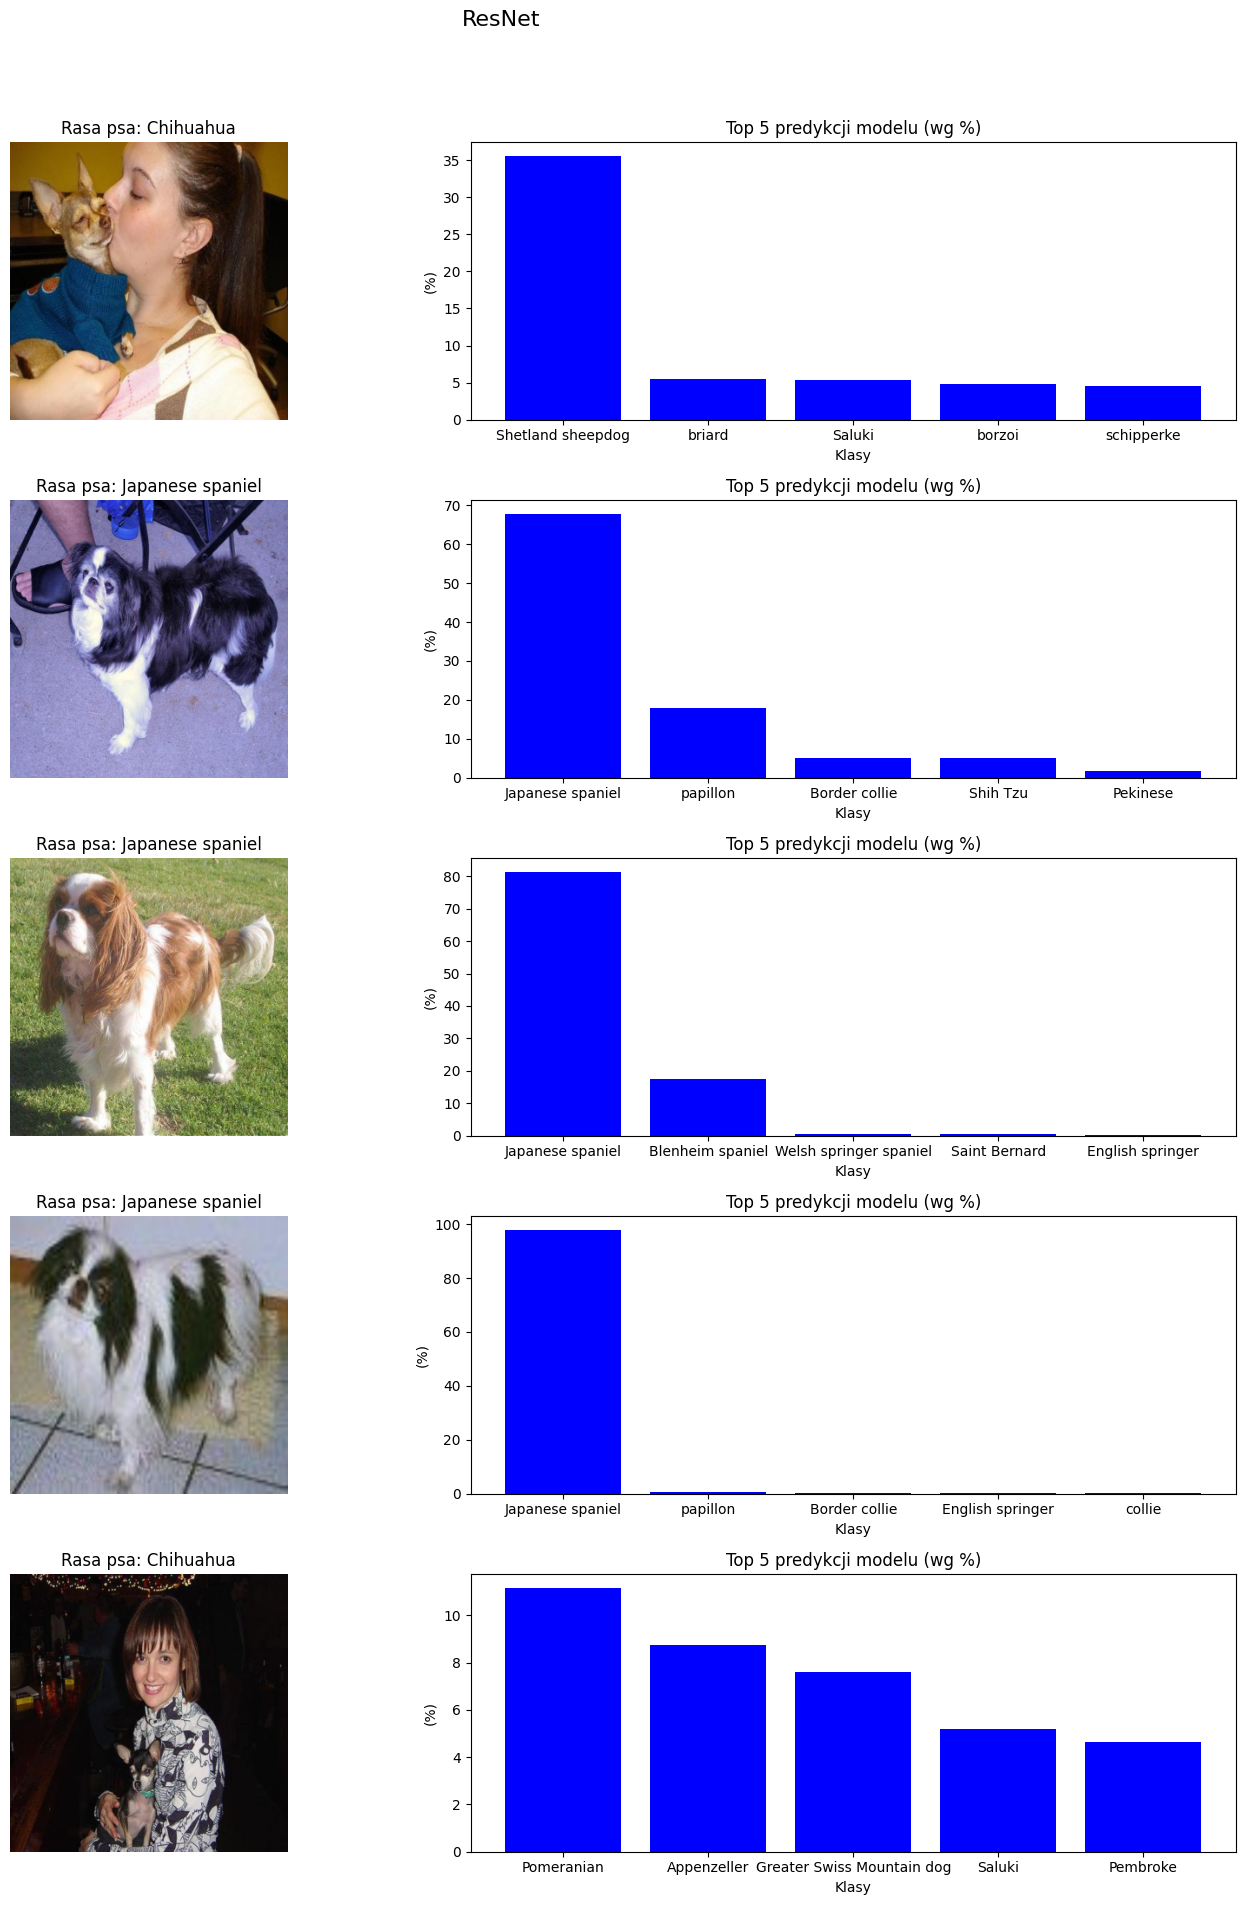

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#pobiera zapisany wybrany model
model_file_name = "/content/drive/MyDrive/Colab Notebooks/dane/pytorch/DogBreedPretrainedResnet152_full_model.pth"
model = torch.load(model_file_name, map_location=device)

# models = [model1, model2, model3, model4, model5, model6, model7]


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model2 = model2.to(device)


positions = [8, 38, 53,33,15]

for model in models:
    model = model.to(device)
    model_name = model.network.__class__.__name__
    model.eval()

    fig, axarr = plt.subplots(len(positions), 2, figsize=(15, 20))
    plt.suptitle(model_name, fontsize=16)

    for idx, position in enumerate(positions):
        image = None
        label = None
        current_pos = 0

        # Iteruj przez test_dl tylko do momentu, aż znajdziesz pozycję, której szukasz.
        for images, labels in test_dl:
            if current_pos + len(images) > position:
                image = images[position - current_pos].unsqueeze(0).to(device)
                label = labels[position - current_pos]
                break
            current_pos += len(images)

        if image is None or label is None:
            continue

        # Wykonaj inferencję
        with torch.no_grad():
            model.eval()
            predictions = model(image)
            probabilities = torch.nn.functional.softmax(predictions, dim=1)[0] * 100

        # Wybierz 5 najbardziej prawdopodobnych klas
        _, top5_idx = torch.topk(probabilities, 5)
        top5_prob = probabilities[top5_idx]

        # Zakładając, że masz listę nazw klas w odpowiedniej kolejności
        class_names = breeds
        top5_classes = [class_names[i] for i in top5_idx.cpu().numpy()]

        # Wyświetl zdjęcie
        axarr[idx, 0].imshow(image[0].cpu().permute(1, 2, 0))
        axarr[idx, 0].axis('off')  # Wyłącz osie na obrazie
        axarr[idx, 0].set_title(f"Rasa psa: {class_names[label]}")

        # Narysuj wykres słupkowy
        axarr[idx, 1].bar(top5_classes, top5_prob.cpu().numpy(), color='blue')
        axarr[idx, 1].set_xlabel("Klasy")
        axarr[idx, 1].set_ylabel("(%)")
        axarr[idx, 1].set_title("Top 5 predykcji modelu (wg %)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## DOKŁADNOŚĆ NA TESTOWEJ BAZIE

In [ ]:
def evaluate_model(model, dataloader, device):
    correct = 0
    total = 0
    total_loss = 0.0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # Wyłącz obliczenia gradientu
        model.eval()  # Przełącz model w tryb ewaluacji
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)  # Pobierz indeksy klas o największym prawdopodobieństwie
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(dataloader)

    return accuracy, average_loss

# Używając powyższej funkcji, możesz obliczyć dokładność dla zestawu testowego:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_file_name = "/content/drive/MyDrive/Colab Notebooks/dane/pytorch/DogBreedPretrainedResnet50_full_model.pth"
model1 = torch.load(model_file_name, map_location=device)
accuracy1, loss1 = evaluate_model(model1, test_dl, device)

model_file_name = "/content/drive/MyDrive/Colab Notebooks/dane/pytorch/DogBreedPretrainedVGG16_full_model.pth"
model2 = torch.load(model_file_name, map_location=device)
accuracy2, loss2 = evaluate_model(model2, test_dl, device)

model_file_name = "/content/drive/MyDrive/Colab Notebooks/dane/pytorch/DogBreedPretrainedVGG19_full_model.pth"
model3 = torch.load(model_file_name, map_location=device)
accuracy3, loss3 = evaluate_model(model3, test_dl, device)

model_file_name = "/content/drive/MyDrive/Colab Notebooks/dane/pytorch/DogBreedPretrainedDenseNet121_full_model.pth"
model4 = torch.load(model_file_name, map_location=device)
accuracy4, loss4 = evaluate_model(model4, test_dl, device)

model_file_name = "/content/drive/MyDrive/Colab Notebooks/dane/pytorch/DogBreedPretrainedInceptionV3_full_model.pth"
model5 = torch.load(model_file_name, map_location=device)
accuracy5, loss5 = evaluate_model(model5, test_dl, device)

model_file_name = "/content/drive/MyDrive/Colab Notebooks/dane/pytorch/DogBreedPretrainedMobileNetV2_full_model.pth"
model6 = torch.load(model_file_name, map_location=device)
accuracy6, loss6 = evaluate_model(model6, test_dl, device)

model_file_name = "/content/drive/MyDrive/Colab Notebooks/dane/pytorch/DogBreedPretrainedResnet152_full_model.pth"
model7 = torch.load(model_file_name, map_location=device)
accuracy7, loss7 = evaluate_model(model7, test_dl, device)






# print(f'Dokładność modelu na zestawie testowym: {accuracy:.2f}%')
# print(f'Strata na zestawie testowym: {loss:.4f}')



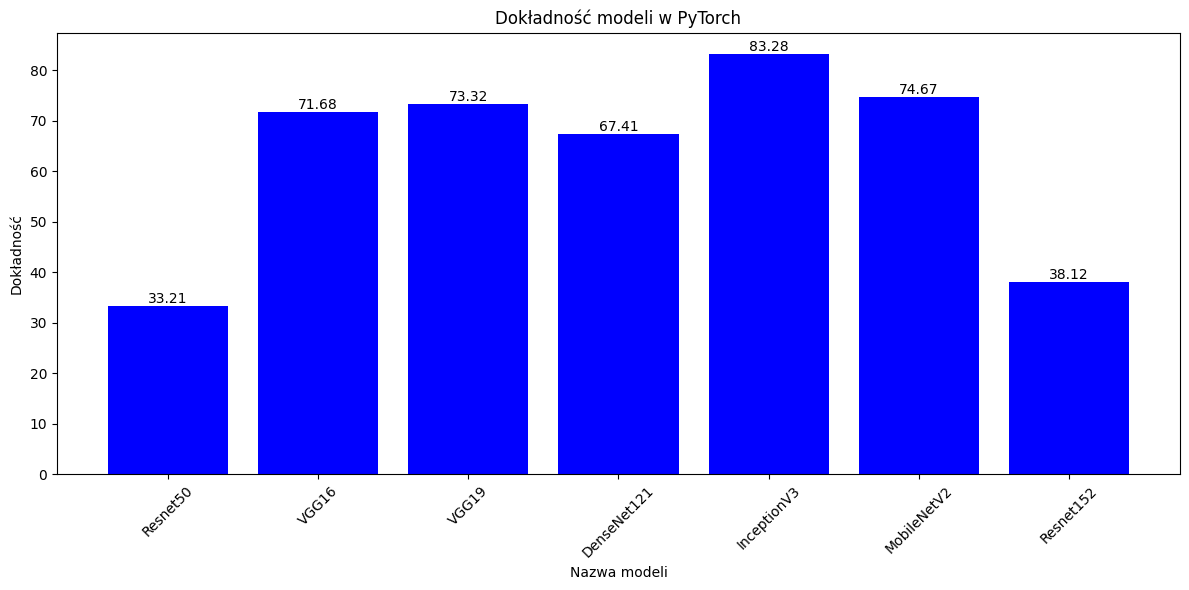

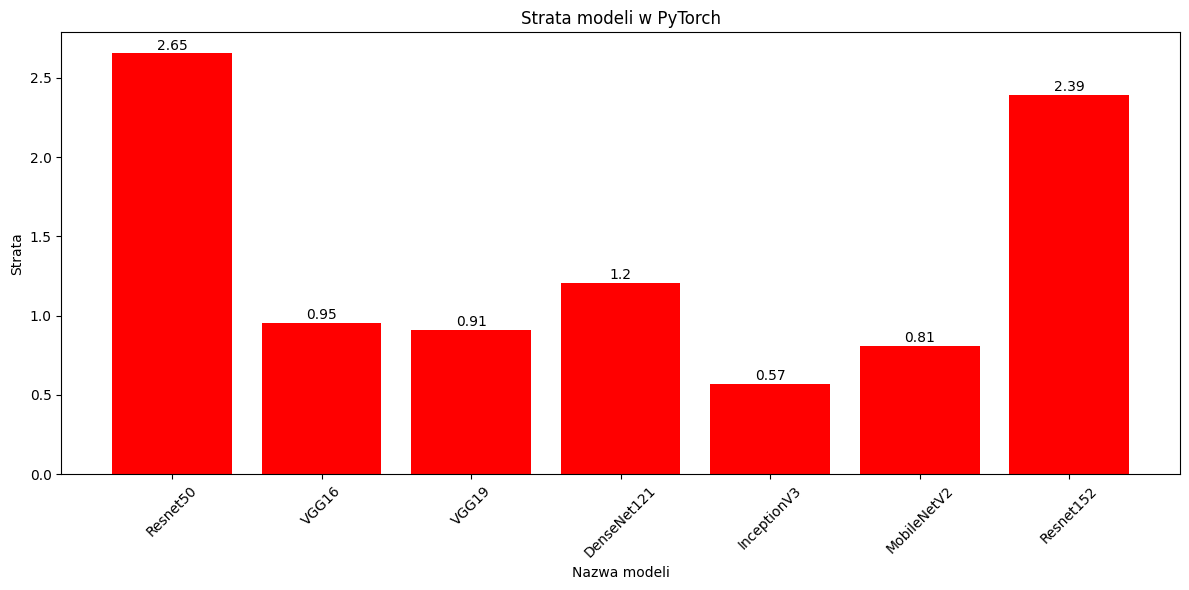

In [ ]:
models = ['Resnet50', 'VGG16', 'VGG19', 'DenseNet121', 'InceptionV3', 'MobileNetV2', 'Resnet152']

# Accuracy values
accuracies = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6, accuracy7]

# Loss values
losses = [loss1, loss2, loss3, loss4, loss5, loss6, loss7]

# # Create bar plot for accuracy
# plt.figure(figsize=(12, 6))
# plt.bar(models, accuracies, color='blue')
# plt.xlabel('Nazwa modeli')
# plt.ylabel('Dokładność')
# plt.title('Dokładność modeli w PyTorch')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Create bar plot for loss
# plt.figure(figsize=(12, 6))
# plt.bar(models, losses, color='red')
# plt.xlabel('Nazwa modeli')
# plt.ylabel('Strata')
# plt.title('Strata modeli w PyTorch')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(12, 6))
bars1 = plt.bar(models, accuracies, color='blue')
plt.xlabel('Nazwa modeli')
plt.ylabel('Dokładność')
plt.title('Dokładność modeli w PyTorch')
plt.xticks(rotation=45)

# Add numerical annotations on top of the bars for accuracy
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Create bar plot for loss
plt.figure(figsize=(12, 6))
bars2 = plt.bar(models, losses, color='red')
plt.xlabel('Nazwa modeli')
plt.ylabel('Strata')
plt.title('Strata modeli w PyTorch')
plt.xticks(rotation=45)

# Add numerical annotations on top of the bars for loss
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()